In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import math
from tqdm import tqdm, trange
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import networkx as nx
import scipy as sp
from linkage_utils import *
from models import *
from PIL import Image
import skimage
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import torch

## Load Curves and Mechanims

In [2]:
target_shape = np.load('n_currated_shapes.npy')
target_mechanisms = np.load('currated_mechanisms.npy', allow_pickle=True)

Plot some random samples and one picked sample from the dataset

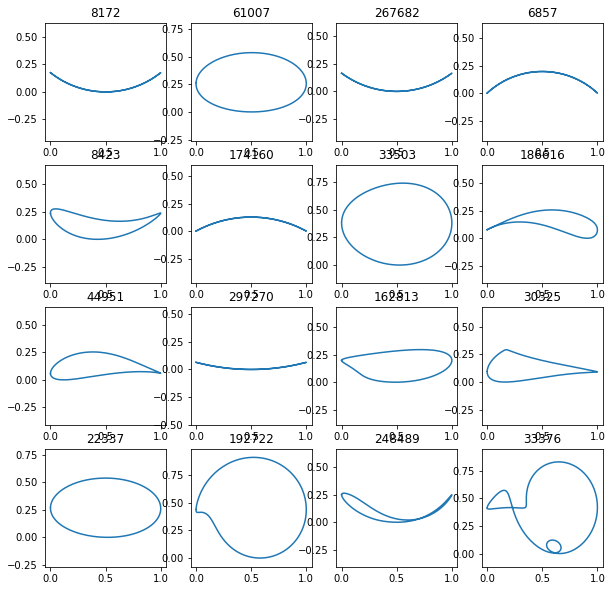

In [3]:
fig, ax = plt.subplots(4,4,figsize=(10,10))

for i in range(16):
    rind = np.random.choice(target_shape.shape[0])
    if i == 15:
        rind = 33376
    ax[i//4,i%4].plot(target_shape[rind][:,0],target_shape[rind][:,1])
    ax[i//4,i%4].set_title(rind)
    
    ax[i//4,i%4].axis('equal')

Draw the mechanims associated with the last shape

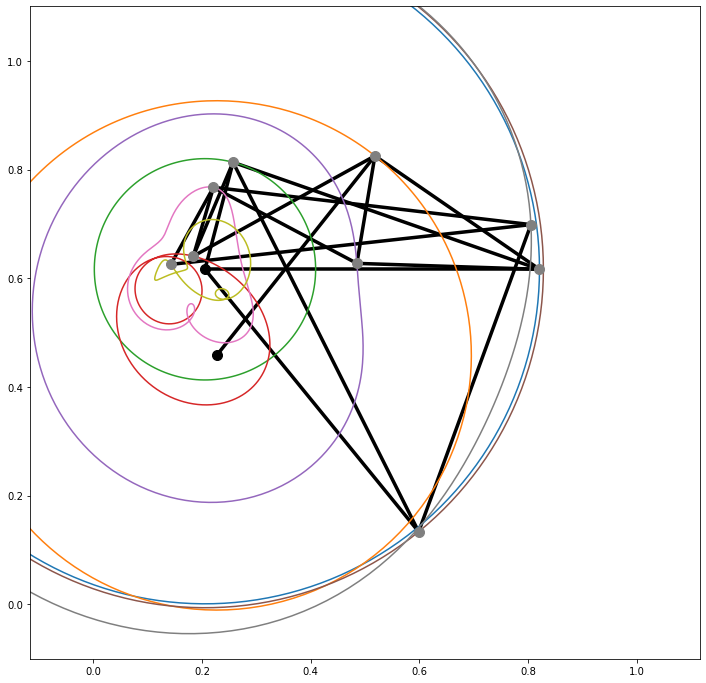

In [4]:
C, x0, fixed_nodes, motor = target_mechanisms[33376]
draw_mechanism(C, x0, fixed_nodes, motor)

## Bezier AE

In [8]:
class BezierVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(BezierVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Res_Encoder(latent_dim)
        self.decoder = Generator(bezier_degree=63,output_size=200)
    
    @tf.function
    def recon(self,x):
        mean, logvar = self.encode(x,training=False)
        z = self.reparameterize(mean, logvar)
        output = self.decode(mean,training=False)
        
        return output
    
    def encode(self, x, training=True):
        mean, logvar = self.encoder(x,training=training)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, training=True):
        d = self.decoder(z,training=training)[0]
        return d
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)
    
    def compute_loss(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        output = self.decode(mean)
#         cd_loss = -tf_cd(tf.squeeze(x),output)
        mse_loss = -tf.reduce_mean(tf.math.square(x-output))
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(mse_loss), -mse_loss
    
    def get_train_step(self):
        @tf.function
        def train_step(x, optimizer, approach='def'):
            
            with tf.GradientTape() as tape:
                loss,mse = self.compute_loss(x)
            
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            return loss,mse
        return train_step
    
    def train(self, data, batch_size=32, epochs = 10, lr=1e-3):
        optimizer = tf.keras.optimizers.Adam(lr)
        n_steps = int(np.ceil(data.shape[0]/batch_size))
        train_step = self.get_train_step()
        
        for j in range(epochs):
            print('Epoch %i:' % (j+1))
            
            inds = np.random.choice(data.shape[0],data.shape[0])

            steps = trange(n_steps)
            l_ov = 0
            for i in steps:
                batch = data[inds[i*batch_size:(i+1)*batch_size]].astype(np.float32)
                batch = np.expand_dims(batch,-1)
                loss,mse = train_step(batch,optimizer)
                l_ov += loss
                
                steps.set_postfix_str('Loss: %f, ovrall_loss: %f, MSE:%f' % (loss,l_ov/(i+1),mse))
            print('Epoch Loss %f:' % (l_ov))

In [9]:
model = BezierVAE(64)

In [10]:
model.train(target_shape[0:250000], lr=tf.keras.optimizers.schedules.ExponentialDecay(
    1e-4,
    decay_steps=8000,
    decay_rate=0.8,
    staircase=True),epochs = 40, batch_size=128)

Epoch 1:



Epoch Loss 7.304987:
Epoch 2:



Epoch Loss 2.073928:
Epoch 3:



Epoch Loss 1.374747:
Epoch 4:



Epoch Loss 1.059328:
Epoch 5:



Epoch Loss 0.776251:
Epoch 6:



Epoch Loss 0.668388:
Epoch 7:



Epoch Loss 0.575992:
Epoch 8:



Epoch Loss 0.508031:
Epoch 9:



Epoch Loss 0.424319:
Epoch 10:



Epoch Loss 0.390825:
Epoch 11:



Epoch Loss 0.360023:
Epoch 12:



Epoch Loss 0.342585:
Epoch 13:



Epoch Loss 0.302107:
Epoch 14:



Epoch Loss 0.275068:
Epoch 15:



Epoch Loss 0.262775:
Epoch 16:



Epoch Loss 0.254708:
Epoch 17:



Epoch Loss 0.234343:
Epoch 18:



Epoch Loss 0.212546:
Epoch 19:



Epoch Loss 0.205172:
Epoch 20:



Epoch Loss 0.199394:
Epoch 21:



Epoch Loss 0.189746:
Epoch 22:



Epoch Loss 0.177528:
Epoch 23:



Epoch Loss 0.170853:
Epoch 24:



Epoch Loss 0.167159:
Epoch 25:



Epoch Loss 0.161953:
Epoch 26:



Epoch Loss 0.152168:
Epoch 27:



Epoch Loss 0.148910:
Epoch 28:



Epoch Loss 0.145508:
Epoch 29:



Epoch Loss 0.140104:
Epoch 30:



Epoch Loss 0.135768:
Epoch 31:



Epoch Loss 0.133029:
Epoch 32:



Epoch Loss 0.129481:
Epoch 33:



Epoch Loss 0.128983:
Epoch 34:



Epoch Loss 0.124453:
Epoch 35:



Epoch Loss 0.121280:
Epoch 36:



Epoch Loss 0.120592:
Epoch 37:



Epoch Loss 0.119999:
Epoch 38:



Epoch Loss 0.113649:
Epoch 39:



Epoch Loss 0.112963:
Epoch 40:



Epoch Loss 0.112662:


Plot reconstruction on the validation set

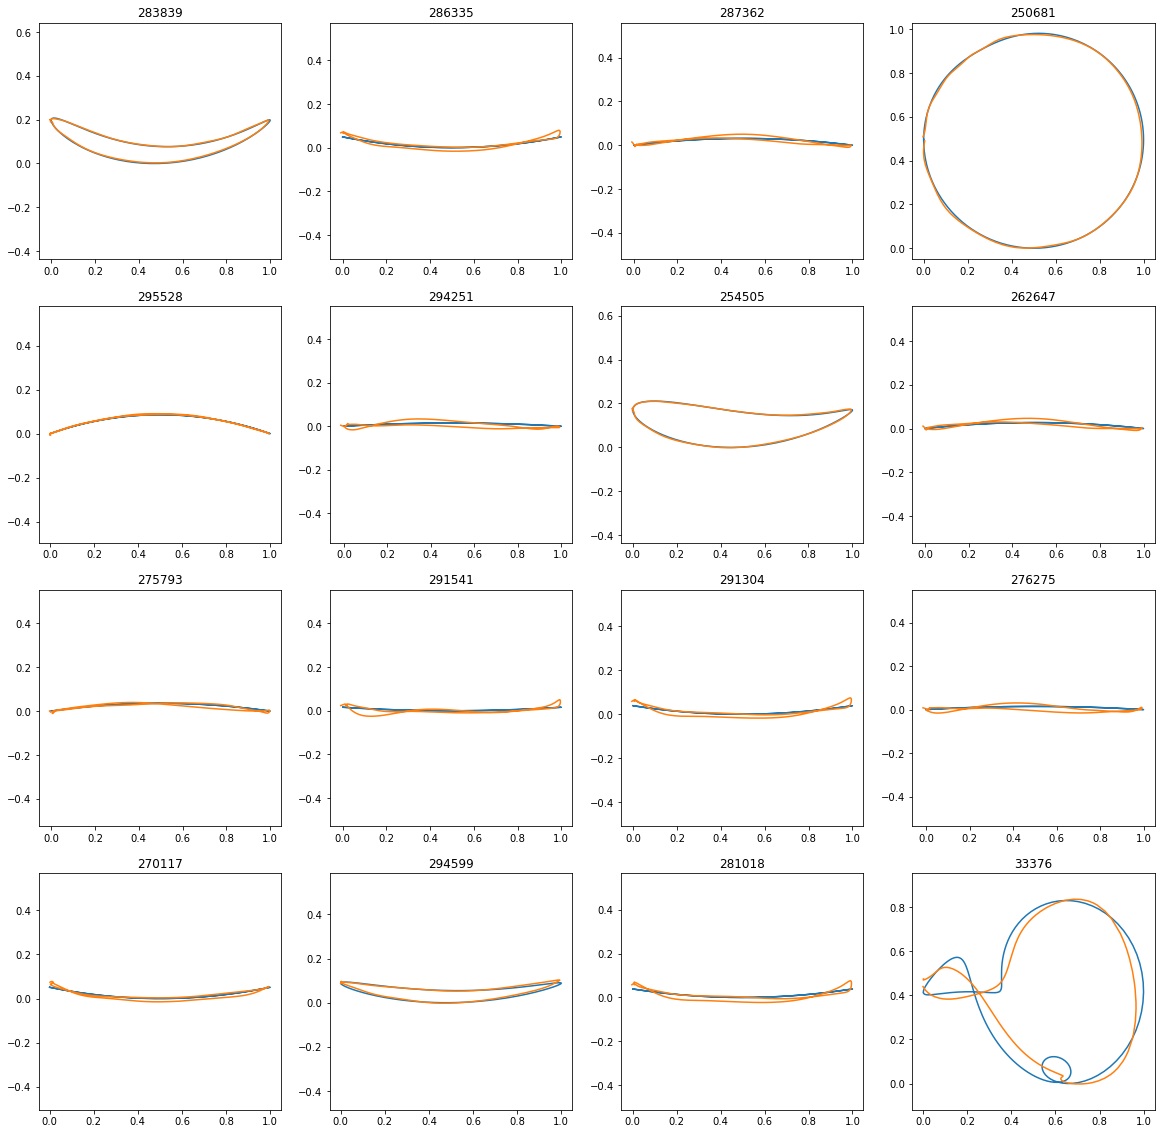

In [11]:
fig, ax = plt.subplots(4,4,figsize=(20,20))
rind = np.random.choice(target_shape[250000:].shape[0],15) + 250000
rind = np.concatenate([rind,[33376]])

batch = np.expand_dims(target_shape[rind],-1)
output = model.recon(batch).numpy()

for i in range(16):
    ax[i//4,i%4].plot(target_shape[rind[i]][:,0],target_shape[rind[i]][:,1])
    ax[i//4,i%4].set_title(rind[i])
    ax[i//4,i%4].plot(output[i][:,0],output[i][:,1])
    ax[i//4,i%4].axis('equal')

## Siren AE

In [12]:
class SirenVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(SirenVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Res_Encoder(latent_dim)
        self.Siren = Siren_Decoder(latent_dim,in_features=1, out_features=2, hidden_features=256, hidden_layers=6, outermost_linear=True)
        self.coords = tf.expand_dims(tf.linspace(-1,1,200),-1)

    def encode(self, x, training=True):
        mean, logvar = self.encoder(x,training=training)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, training=True):
        Batch_Size = tf.shape(z)[0]
        zs = tf.reshape(tf.tile(tf.expand_dims(z,1),[1,200,1]),[-1,self.latent_dim])
        coords = tf.tile(self.coords,[Batch_Size,1])
        d = self.Siren(coords,zs,training=training)
        d = tf.reshape(d, [-1,200,2])
        return d
    
    @tf.function
    def recon(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        output = self.decode(mean)
        
        return output
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        output = self.decode(mean)
#         cd_loss = -tf_cd(tf.squeeze(x),output)
        mse_loss = -tf.reduce_mean(tf.math.square(tf.squeeze(x,-1)-output))
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(mse_loss), -mse_loss
    
    def get_train_step(self):
        @tf.function
        def train_step(x, optimizer, approach='def'):
            
            with tf.GradientTape() as tape:
                loss, mse = self.compute_loss(x)
                
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            return loss, mse
        return train_step
    
    def train(self, data, batch_size=32, epochs = 10, lr=1e-3):
        optimizer = tf.keras.optimizers.Adam(lr)
        n_steps = int(np.ceil(data.shape[0]/batch_size))
        train_step = self.get_train_step()
        
        for j in range(epochs):
            print('Epoch %i:' % (j+1))
            
            inds = np.random.choice(data.shape[0],data.shape[0])

            steps = trange(n_steps)
            l_ov = 0
            for i in steps:
                batch = data[inds[i*batch_size:(i+1)*batch_size]].astype(np.float32)
                batch = (np.expand_dims(batch,-1) - 0.5)/0.5
                loss,mse = train_step(batch,optimizer)
                l_ov += loss
                
                steps.set_postfix_str('Loss: %f, ovrall_loss: %f, MSE:%f' % (loss,l_ov/(i+1),mse))
            print('Epoch Loss %f:' % (l_ov))

In [16]:
model = SirenVAE(64)

In [17]:
model.train(target_shape[0:250000], batch_size=128, lr=tf.keras.optimizers.schedules.ExponentialDecay(
    1e-4,
    decay_steps=8000,
    decay_rate=0.8,
    staircase=True),epochs = 40)

Epoch 1:



Epoch Loss 58.186638:
Epoch 2:



Epoch Loss 28.429920:
Epoch 3:



Epoch Loss 24.035168:
Epoch 4:



Epoch Loss 22.252193:
Epoch 5:



Epoch Loss 18.652899:
Epoch 6:



Epoch Loss 18.067745:
Epoch 7:



Epoch Loss 16.351748:
Epoch 8:



Epoch Loss 15.863579:
Epoch 9:



Epoch Loss 14.091900:
Epoch 10:



Epoch Loss 13.611223:
Epoch 11:



Epoch Loss 13.097905:
Epoch 12:



Epoch Loss 12.584254:
Epoch 13:



Epoch Loss 12.437134:
Epoch 14:



Epoch Loss 10.999924:
Epoch 15:



Epoch Loss 11.145619:
Epoch 16:



Epoch Loss 11.118991:
Epoch 17:



Epoch Loss 9.665050:
Epoch 18:



Epoch Loss 8.655213:
Epoch 19:



Epoch Loss 8.254570:
Epoch 20:



Epoch Loss 8.767263:
Epoch 21:



Epoch Loss 7.984145:
Epoch 22:



Epoch Loss 6.918830:
Epoch 23:



Epoch Loss 6.813776:
Epoch 24:



Epoch Loss 6.726601:
Epoch 25:



Epoch Loss 6.512631:
Epoch 26:



Epoch Loss 5.686513:
Epoch 27:



Epoch Loss 5.579036:
Epoch 28:



Epoch Loss 5.530318:
Epoch 29:



Epoch Loss 5.258712:
Epoch 30:



Epoch Loss 4.832741:
Epoch 31:



Epoch Loss 4.599988:
Epoch 32:



Epoch Loss 4.701113:
Epoch 33:



Epoch Loss 4.550919:
Epoch 34:



Epoch Loss 4.010391:
Epoch 35:



Epoch Loss 4.026117:
Epoch 36:



Epoch Loss 3.966609:
Epoch 37:



Epoch Loss 3.840723:
Epoch 38:



Epoch Loss 3.606053:
Epoch 39:



Epoch Loss 3.461782:
Epoch 40:



Epoch Loss 3.386059:


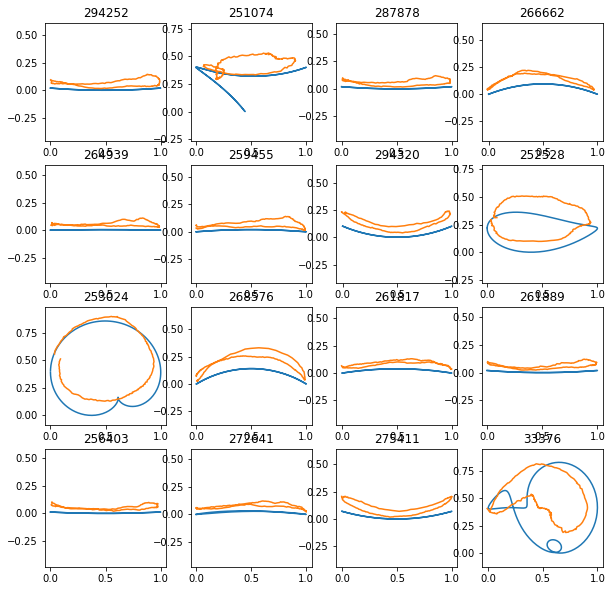

In [18]:
fig, ax = plt.subplots(4,4,figsize=(10,10))
rind = np.random.choice(target_shape[250000:].shape[0],15)+250000
rind = np.concatenate([rind,[33376]])

batch = (np.expand_dims(target_shape[rind],-1) - 0.5)/0.5
output = model.recon(batch).numpy() * 0.5 +0.5

for i in range(16):
    ax[i//4,i%4].plot(target_shape[rind[i]][:,0],target_shape[rind[i]][:,1])
    ax[i//4,i%4].set_title(rind[i])
    ax[i//4,i%4].plot(output[i][:,0],output[i][:,1])
    ax[i//4,i%4].axis('equal')

## First Attempt At Differential Solver

In [ ]:
class solver():
    def __init__(self):
        self.x = tf.Variable(tf.zeros([1000,2]))
        self.visited_list = tf.Variable(tf.zeros(1000))
        self.active_list = tf.Variable(tf.zeros(1000)-1)
        self.pi = tf.constant(pi)
        
    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def get_dist(self,x,x0):
        return tf.linalg.norm(x0[x[0]]-x0[x[1]])
    
    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def find_neighbors(self,index,C):
        return tf.reshape(tf.where(C[index]),[-1])

    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def find_unvisited_neighbors(self,index, C, visited_list):
        neighbors = self.find_neighbors(index, C)
        relavent = tf.gather(visited_list,neighbors)
        return tf.reshape(tf.gather(neighbors,tf.where(tf.logical_not(relavent))),[-1])
    
    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def find_visited_neighbors(self,index, C, visited_list):
        neighbors = self.find_neighbors(index, C)
        relavent = tf.gather(visited_list,neighbors)
        vn = tf.reshape(tf.gather(neighbors,tf.where(relavent)),[-1])
        return vn
    
    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def getG(self,x0,C):
        edges = tf.where(C)
        dist_vals = tf.map_fn(lambda x: self.get_dist(x,x0) ,edges,x0.shape[0],fn_output_signature=tf.float32)
        G = tf.sparse.to_dense(tf.SparseTensor(indices=edges, values=dist_vals, dense_shape=C.shape))
        return G
    
    @tf.function
    @tf.autograph.experimental.do_not_convert   
    def process_node(self,n,C,G,x0):
        
        N = C.shape[0]
        neighbors = self.find_neighbors(n, C)
        
        vn = self.find_visited_neighbors(n,C,tf.cast(self.visited_list[0:N],tf.bool)) # indices of visited neighbors
        
        def calc():
            i = vn[0]
            j = vn[1]
            l_ij = tf.linalg.norm(self.x[j]-self.x[i])
            
            s = tf.sign((x0[i,1]-x0[n,1])*(x0[i,0]-x0[j,0]) - (x0[i,1]-x0[j,1])*(x0[i,0]-x0[n,0]))
            cosphi = (l_ij**2+G[i,n]**2-G[j,n]**2)/(2*l_ij*G[i,n])
            
            def calc_pos():
                phi = s * tf.math.acos(cosphi)
                R =[[tf.math.cos(phi), -tf.math.sin(phi)],
                    [tf.math.sin(phi), tf.math.cos(phi)]]
               
                scaled_ij = tf.reshape(((self.x[j]-self.x[i])/l_ij * G[i,n]),[2,1])
                
                self.x[n].assign(tf.squeeze(tf.matmul(R, scaled_ij)) + self.x[i])
                self.visited_list[n].assign(1)
                return 1
            
            return tf.cond(tf.logical_and(cosphi >= -1.0,cosphi <= 1.0),calc_pos,lambda: -1)
            
        return tf.cond(tf.shape(vn)[0]>1,calc,lambda: 0)
    
    
    
    
    @tf.function
    @tf.autograph.experimental.do_not_convert    
    def position(self,theta, x0, C, G, fixed_nodes=tf.constant([0, 1]), show_msg=False):
        
        #reset Auxilary Vars
        self.x.assign(self.x*0)
        self.visited_list.assign(self.visited_list*0)
        self.active_list.assign(self.active_list*0-1)
        
        N = C.shape[0]
        
        for i in range(fixed_nodes.shape[0]):
            self.x[fixed_nodes[i]].assign(x0[fixed_nodes[i]])
        
        motor_neighbor = self.find_neighbors(0, C)[0]
        
        dx = x0[motor_neighbor,0] - x0[0,0]
        dy = x0[motor_neighbor,1] - x0[0,1]
        
        theta_0 = tf.math.atan2(dy,dx)
        theta = theta_0 + theta
        
        self.x[motor_neighbor, 0].assign(self.x[0,0] + G[0,motor_neighbor] * tf.math.cos(theta))
        self.x[motor_neighbor, 1].assign(self.x[0,1] + G[0,motor_neighbor] * tf.math.sin(theta))
        
        initial_nodes = tf.concat([fixed_nodes,[motor_neighbor]],-1)
        
        for i in range(fixed_nodes.shape[0]+1):
            self.visited_list[initial_nodes[i]].assign(1)
        
        
        active_list = tf.reshape(tf.where(tf.logical_not(tf.cast(self.visited_list[0:N],tf.bool))),[-1])
        fails = 0
        counter = 0
        unsolved = tf.cast(tf.shape(active_list)[0],tf.int32)
        for i in range(N - fixed_nodes.shape[0] - 1):
            returns = tf.map_fn(lambda n: self.process_node(n,C,G,x0),active_list,fn_output_signature=tf.int32,parallel_iterations=1000)
            fails = tf.cast(tf.shape(tf.reshape(tf.where(returns==-1),[-1]))[0],tf.int32)
            active_list = tf.reshape(tf.where(tf.logical_not(tf.cast(self.visited_list[0:N],tf.bool))),[-1])
        
            unsolved = tf.cast(tf.shape(active_list)[0],tf.int32)
        if show_msg:
            tf.cond(unsolved!=0,lambda: tf.print('DOF larger than 1'), lambda: tf.print('DOF good!'))
            tf.cond(fails!=0,lambda: tf.print('Degenerate or Locked!'),lambda: tf.print('Solved!'))
        return self.x[0:N]
    
    @tf.function
    def solve_revolution(self, n_steps, x0, C, fixed_nodes=tf.constant([0, 1]), show_msg=False):
        # Create a weighted graph where edges represent bar lengths
        G = self.getG(x0,C)
        
        theta = tf.linspace(0.0,2*self.pi,n_steps)
        
        return tf.map_fn(lambda t: self.position(t, x0, C, G, fixed_nodes, show_msg),theta,parallel_iterations=n_steps,fn_output_signature=tf.float32)
    
    @tf.function
    def solve_batch(self,n_steps,x0s,Cs,fixed_nodes):
        return tf.map_fn(lambda inp: self.solve_revolution(n_steps,inp[0],inp[1],inp[2]),(x0s,Cs,fixed_nodes),parallel_iterations=Cs.shape[0],fn_output_signature=tf.float32)